## Pioneer Research Project
Author: Yuxing Zhou

This notebook is executable on Kaggle as a Kaggle Kernel with two private custom datasets. The two datasets are modified versions of originally publicly available datasets that I have used with permission. Since the datasets aren't available publicly, I sampled some images from the datasets I used as well as some of the results my model produced. These are shown as outputs in this notebook.

The training took place entirely on the Kaggle platform with GPU turned on.

Links to original datasets:

https://www.kaggle.com/laurentmih/aisegmentcom-matting-human-datasets
http://xiaoyongshen.me/webpages/webpage_automatting/



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import sys
import random
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import callbacks
import tensorflow.keras.backend as K
import glob

from PIL import Image
import glob

import tensorflow as tf
import time
import cv2

In [3]:
print(tf.__version__)
print(cv2.__version__)

1.14.0
4.1.0


In [4]:
!which python3
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

/opt/conda/bin/python3
Name: /physical_device:GPU:0   Type: GPU


In [5]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
#TRAIN_PATH = './dataset/training/'
#TEST_PATH = './dataset/testing/'
TRAIN_NUM = 1700
TEST_NUM = 300
sample_dir = "/kaggle/input/human-segmentation-large/newdataset/train/img/"
mask_dir = "/kaggle/input/human-segmentation-large/newdataset/train/mask/"
test_sample_dir = "/kaggle/input/human-img-seg/dataset_kaggle/testing/sample/"
test_mask_dir = "/kaggle/input/human-img-seg/dataset_kaggle/testing/mask/"


In [6]:
#Get the filenames of training and testing data
sample_ids = next(os.walk(sample_dir))[2]
test_sample_ids = next(os.walk(test_sample_dir))[2]
print(sample_ids[:10])
print(test_sample_ids[:10])

['1803151818-00022600.png', '1803151818-00009705.png', '1803151818-00023037.png', '1803151818-00019280.png', '1803151818-00022932.png', '1803151818-00010196.png', '1803151818-00018653.png', '1803151818-00020163.png', '1803151818-00019218.png', '1803151818-00010402.png']
['00119.png', '00045.png', '00065.png', '00108.png', '00163.png', '00181.png', '00067.png', '00156.png', '00203.png', '00116.png']


In [7]:
save_model_path = './myIOU_weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

### Create a custom image batch generator 
This generator class is used for generating batches of training and testing images for the model.fit_generator(). By using the albumentations library, we are able to perform online random image augmentation or the training data.

In [8]:
batch_size = 8

class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
    def __init__(self, train_im_path=sample_dir,train_mask_path=mask_dir,
                 augmentations=None, batch_size=batch_size,img_size=512, n_channels=3, shuffle=True, mode="train"):
#         'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.mode = mode

        self.on_epoch_end()

    def __len__(self):
#         'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)
        # First generate data
        #Then rescale them
 
        if self.augment is None:
            return X.astype(np.float32)/255,np.array(y).astype(np.float32)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                aug_im = augmented['image']
                aug_mask = augmented['mask']
#                 print("augmented image data type:", aug_im.dtype)
#                 print("augmented mask data type:", aug_mask.dtype)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
                
                return_im = np.array(im)
                return_mask = np.array(mask)
                return_im = return_im.astype(np.float32)/255
                return_mask = return_mask.astype(np.float32)/255
                
            return return_im, return_mask

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))
        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = cv2.imread(im_path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            if self.mode == "train":
                pass
            else:
                mask_path = mask_path[:-4]+"_matte.png"
                
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if len(im.shape)==2:
                print("shape before:", im.shape)
                im = np.repeat(im[...,None],3,2)
                print("shape after:",im.shape)
                
#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
        
            #USING cv2.resize(), the values are between 0 and 255
            y[y>64] = 255
            y[y <64] = 0
        
        return X,y 

In [9]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.7),
    OneOf([
        RandomGamma(gamma_limit=(90,100), p=0.5),
        MotionBlur(blur_limit=5,p=0.5)
         ], p=0.6),
    OneOf([
        ElasticTransform(p =0.5),
        GridDistortion(num_steps=2, distort_limit=0.3,p=0.5),
        ], p=0.8)
#     ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
#     ToFloat(max_value=1)
],p=1)

#### Here we test our image generator

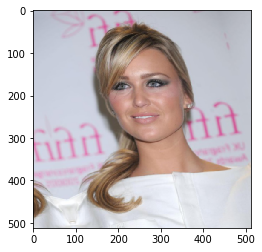

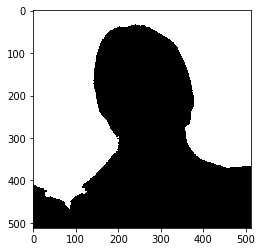

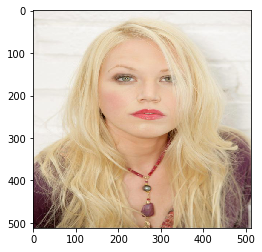

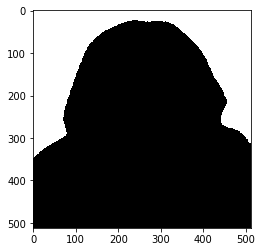

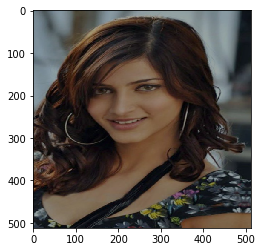

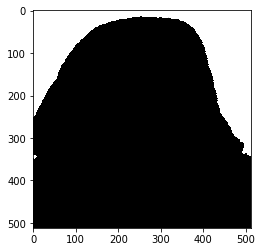

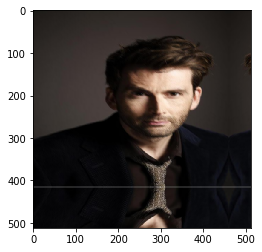

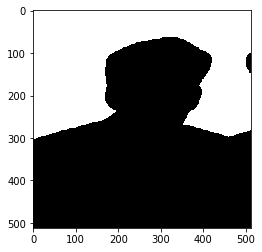

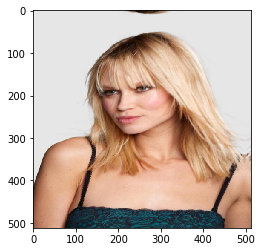

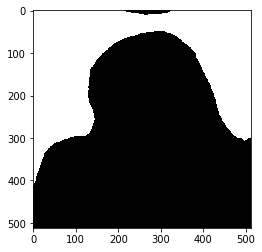

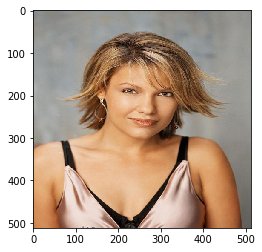

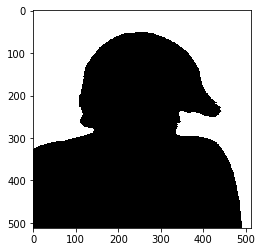

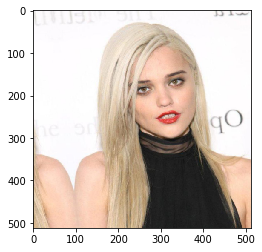

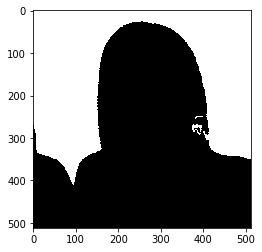

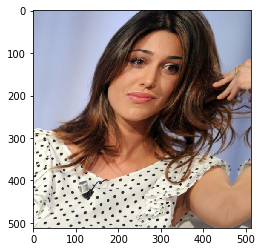

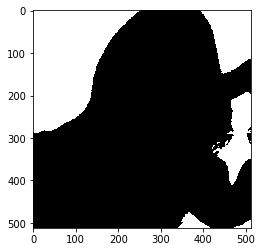

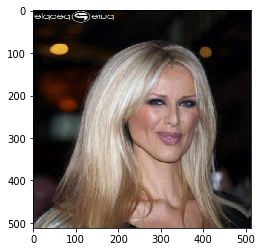

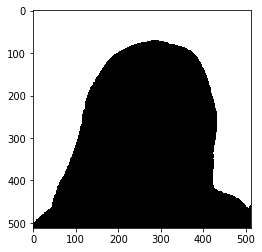

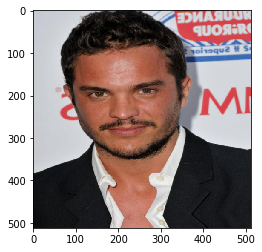

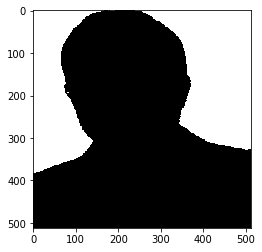

In [10]:
a = DataGenerator(batch_size=15,shuffle=False, augmentations=AUGMENTATIONS_TRAIN)
gen_images,gen_masks = a.__getitem__(0)

for i in range(10):
#     img = gen_images[i].astype(np.uint8)

    img = gen_images[i]
    gt = gen_masks[i]
    plt.imshow(img)
#     print(img[200:230, 200:240])
    plt.show()
    plt.imshow(gt.squeeze(), cmap = "Greys")
#     print(gt.squeeze()[200:230, 200:240])
    plt.show()

### Setting up two generators for training the model

In [11]:
# Here the two generators are instantiated to fit in the model.fit_generator()
batchSize = 6
print(sample_dir)
print(mask_dir)
print(test_sample_dir)
print(test_mask_dir)

training_generator = DataGenerator(batch_size= batchSize, 
                                   augmentations=AUGMENTATIONS_TRAIN,
                                   img_size=IMG_HEIGHT, #512 x 512
                                   mode = "train")

validation_generator = DataGenerator(batch_size=batchSize,
                                     train_im_path = test_sample_dir,
                                     train_mask_path=test_mask_dir,
                                     augmentations=None,
                                     img_size=IMG_HEIGHT, #512 x 512
                                     mode = "test")


/kaggle/input/human-segmentation-large/newdataset/train/img/
/kaggle/input/human-segmentation-large/newdataset/train/mask/
/kaggle/input/human-img-seg/dataset_kaggle/testing/sample/
/kaggle/input/human-img-seg/dataset_kaggle/testing/mask/


### Defining the model and evaluation metrics

In [12]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
  
def myIOU(y_true, y_pred):
    smooth = 0.001
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

In [13]:
def dilated_conv_block(input_tensor, num_filters):
    '''
    Number of filters (num_filters) : the number of input and output channels.
        the block doesn't change output shape
    
    NOTE
        set the the depth separable convolution's filter_num to different sizes
            and see how the parameters change.

    '''
    # Direct 1x1 convolution
    encoderONE = layers.Conv2D(int(num_filters/4), (1,1), padding = "same", use_bias=False)(input_tensor)
    encoderONE = layers.BatchNormalization()(encoderONE)
    encoderONE = layers.Activation('relu')(encoderONE)
    
    #1x1 convolution
    encoderTWO = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    # 5x5 depthwise separable convolution stride 1 dilation_rate = 2
    encoderTWO = layers.SeparableConv2D(int(num_filters/4), (5,5), dilation_rate = 2, padding = "same", use_bias=False, depth_multiplier=2)(encoderTWO)
    encoderTWO = layers.BatchNormalization()(encoderTWO)
    encoderTWO = layers.Activation('relu')(encoderTWO)
    
    #1x1 convolution
    encoderTHR = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    # 3x3 depthwise separable convolution stride 1 dilation_rate = 2
    encoderTHR = layers.SeparableConv2D(int(num_filters/4), (3,3), dilation_rate = 2, padding = "same", use_bias=False, depth_multiplier=2)(encoderTHR)
    encoderTHR = layers.BatchNormalization()(encoderTHR)
    encoderTHR = layers.Activation('relu')(encoderTHR)
    
    #1x1 convolution
    encoderFOUR = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    # 5x5 depthwise separable convolution stride 1 dilation_rate = 2
    encoderFOUR = layers.SeparableConv2D(int(num_filters/4), (5,5), dilation_rate = 3, padding = "same", use_bias=False, depth_multiplier=2)(encoderFOUR)
    encoderFOUR = layers.BatchNormalization()(encoderFOUR)
    encoderFOUR = layers.Activation('relu')(encoderFOUR)
    
    encoderOUT = layers.concatenate([encoderFOUR,encoderTHR, encoderTWO, encoderONE], axis=-1)
    #Final 1x1 convolution with relu to make sure the output have the same channels as input
#     encoderOUT = layers.Conv2D(num_filters, (1,1), padding = "same", use_bias=False)(encoderOUT)
#     encoderOUT = layers.Activation("relu")(encoderOUT)

    return encoderOUT

def downsample_block(input_tensor, num_filters):
    
    #Store the input to this "max_pooling layer" for skip connections
    store_feature =  layers.Conv2D(int(num_filters/4), (1,1), padding = "same", use_bias=False)(input_tensor)
    
    encoder = layers.Conv2D(int(num_filters/2), (1,1), padding = "same", use_bias=False)(input_tensor)
    
    # 2x2 max_pooling with stride 2
    encoderONE = layers.MaxPooling2D((2, 2), strides=(2, 2))(input_tensor) #already have output dimension desired

    # 5x5 depthwise separable convolution stride = 2
    encoderTWO = layers.ZeroPadding2D(padding=(2, 2))(encoder) # zero-padding (2,2) to keep output dimension consistent
    encoderTWO = layers.SeparableConv2D(num_filters, (5,5), strides = 2, use_bias=False)(encoderTWO)
    encoderTWO = layers.BatchNormalization()(encoderTWO)
    encoderTWO = layers.Activation('relu')(encoderTWO)
    
    # 3x3 depthwise separable convolution stride = 2
    encoderTHR = layers.ZeroPadding2D(padding = (1,1))(encoder) # zero-padding (1,1) to keep output dimension consistent
    encoderTHR = layers.SeparableConv2D(num_filters, (3,3), strides = 2, use_bias=False)(encoderTHR)
    encoderTHR = layers.BatchNormalization()(encoderTHR)
    encoderTHR = layers.Activation('relu')(encoderTHR) 

    
    # 7x7 depthwise separable convolution stride = 2
    encoderFOUR = layers.ZeroPadding2D(padding=(3, 3))(encoder) # zero-padding (3,3)to keep output dimension consistent
    encoderFOUR = layers.SeparableConv2D(num_filters, (7,7), strides = 2, use_bias=False)(encoderFOUR)
    encoderFOUR = layers.BatchNormalization()(encoderFOUR)
    encoderFOUR = layers.Activation('relu')(encoderFOUR)
 
    #By now the encoderOUT has shape reduced to 1/2 of input shape
    encoderOUT = layers.concatenate([encoderFOUR, encoderTHR, encoderTWO, encoderONE], axis=-1)
    #Final 1x1 convolution with relu to make sure the output have 2 times channels as input
    encoderOUT = layers.Conv2D(num_filters*2, (1,1), padding = "same", use_bias=False)(encoderOUT)
    encoderOUT = layers.Activation("relu")(encoderOUT)
    
    return store_feature, encoderOUT

def decoder_block(input_tensor, concat_tensor, num_filters):
    
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
#     decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder)
#     decoder = layers.BatchNormalization()(decoder)
#     decoder = layers.Activation('relu')(decoder)
    return decoder

In [14]:
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(img_shape)

#The initial block aggressively downsamples this image to 256 x 256
inputs = layers.Input(shape=img_shape)
initial_block_2 = layers.MaxPool2D((2,2), strides = 2)(inputs)
initial_block_1 = layers.ZeroPadding2D(padding = (1,1))(inputs)
initial_block_1 = layers.Conv2D(29, (3,3), strides = 2, use_bias = False)(initial_block_1)

initial_block = layers.concatenate([initial_block_1, initial_block_2], axis = -1)

# Final Ouput of downsampling: 128
encoder0 = dilated_conv_block(initial_block, 32)
encoder0, encoder0_pool = downsample_block(encoder0, 32)

# Final Ouput of downsampling: 64
encoder1 = dilated_conv_block(encoder0_pool, 64)
encoder1, encoder1_pool = downsample_block(encoder1, 64)

# Final Ouput of downsampling: 32
encoder2 = dilated_conv_block(encoder1_pool, 128)
encoder2, encoder2_pool = downsample_block(encoder2, 128)

# Final Ouput of downsampling: 16
encoder3 = dilated_conv_block(encoder2_pool, 256)
encoder3, encoder3_pool = downsample_block(encoder3, 256)

# Feature map dimension is not changed 
center = dilated_conv_block(encoder3_pool, 512)
center = dilated_conv_block(center, 512)

# After upsampling and concatenation 32
decoder3 = decoder_block(center, encoder3, 256)
# After upsampling and concatenation 64
decoder2 = decoder_block(decoder3, encoder2, 128)
# After upsampling and concatenation 128
decoder1 = decoder_block(decoder2, encoder1, 64)
# After upsampling and concatenation 256
decoder0 = decoder_block(decoder1, encoder0, 32)

# Perform simple bi-linear upsampling to restore 512 x 512 image 
final = layers.UpSampling2D((2,2), interpolation= "bilinear")(decoder0)
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(final)

model = None
model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

(512, 512, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 29) 783         zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
________________________________________________________________________________

In [15]:
opt = tf.keras.optimizers.Adam(lr =0.002)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[dice_loss, myIOU])

In [16]:
!ls /kaggle/input

human-img-seg  human-segmentation-large  trained-for-30-epochs


In [17]:
# Load existing model that has been trained for a while
model = models.load_model("/kaggle/input/trained-for-30-epochs/kaggle_myIOU_weights.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss, 'myIOU':myIOU})

In [18]:
# Train the model from scratch for 30 epochs, the best performing weights on the validation set will be stored.
# In this case, the whole testing dataset is used for validation set.
history = model.fit_generator(training_generator,
                    epochs=13,
                    validation_data = validation_generator,
                    callbacks=[cp],
                    verbose =1,
                    workers=8
                    )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less


Epoch 1/13
1730/1731 [============================>.] - ETA: 1s - loss: 0.0456 - dice_loss: 0.0129 - myIOU: 0.9230
Epoch 00001: val_loss improved from inf to 0.12329, saving model to ./myIOU_weights.hdf5
1731/1731 [==============================] - 1974s 1s/step - loss: 0.0456 - dice_loss: 0.0129 - myIOU: 0.9230 - val_loss: 0.1233 - val_dice_loss: 0.0271 - val_myIOU: 0.8863
Epoch 2/13
1730/1731 [============================>.] - ETA: 1s - loss: 0.0452 - dice_loss: 0.0128 - myIOU: 0.9253
Epoch 00002: val_loss improved from 0.12329 to 0.10814, saving model to ./myIOU_weights.hdf5
1731/1731 [==============================] - 1888s 1s/step - loss: 0.0452 - dice_loss: 0.0128 - myIOU: 0.9253 - val_loss: 0.1081 - val_dice_loss: 0.0250 - val_myIOU: 0.8676
Epoch 3/13
1730/1731 [============================>.] - ETA: 1s - loss: 0.0440 - dice_loss: 0.0125 - myIOU: 0.9252
Epoch 00003: val_loss did not improve from 0.10814
1731/1731 [==============================] - 1899s 1s/step - loss: 0.0440 - 

In [19]:
model.save("./maybe_overfitting.hdf5")

In [20]:
test_generator = DataGenerator(batch_size=1,train_im_path = test_sample_dir ,
                                     train_mask_path=test_mask_dir,
                                     augmentations=None,
                                     img_size=IMG_HEIGHT,
                                    mode = "test")

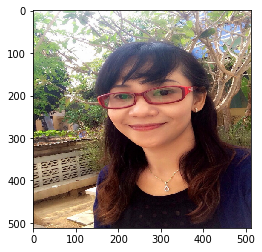

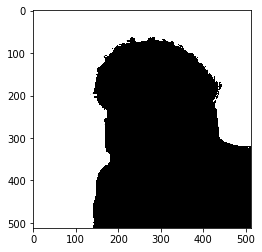

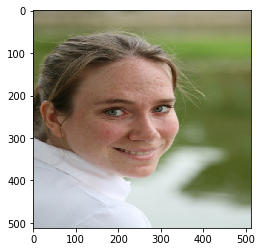

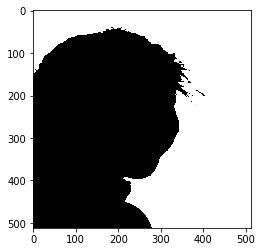

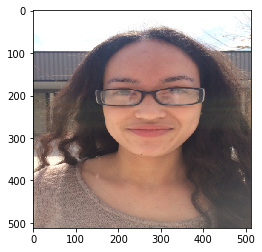

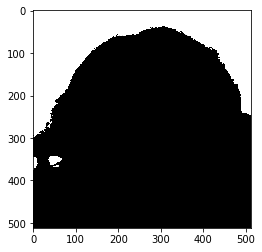

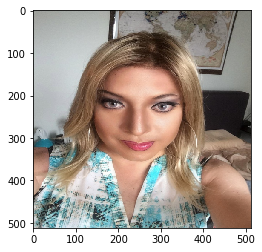

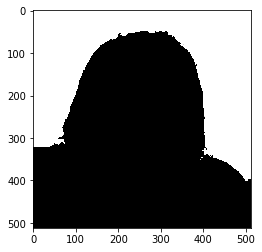

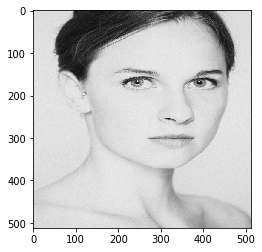

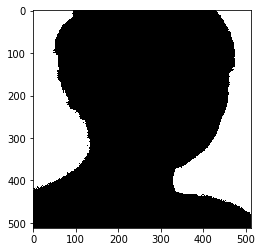

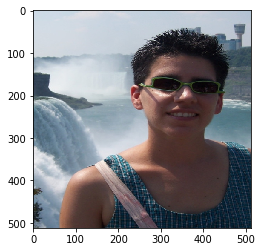

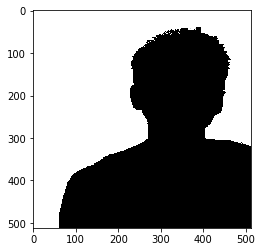

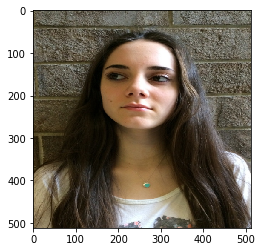

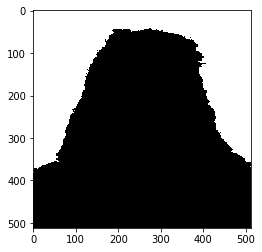

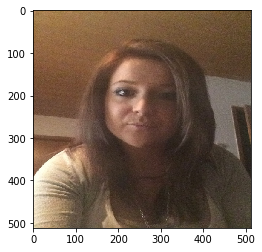

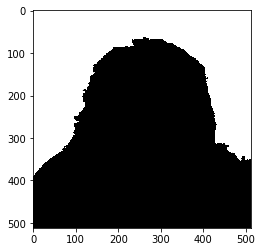

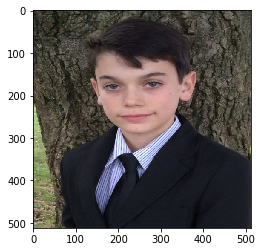

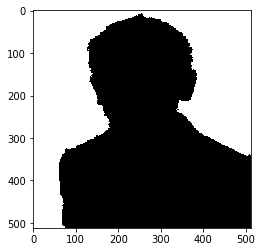

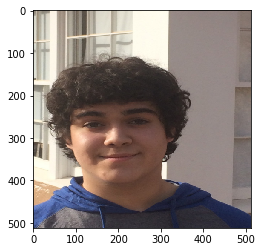

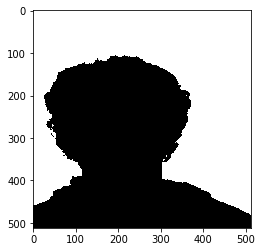

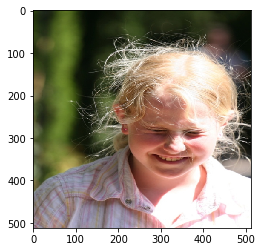

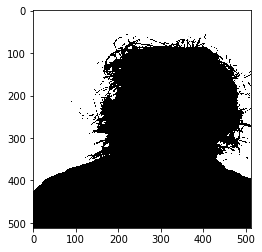

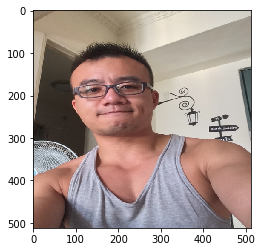

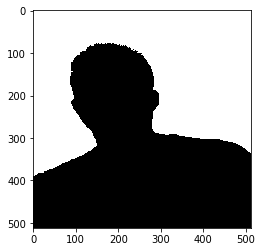

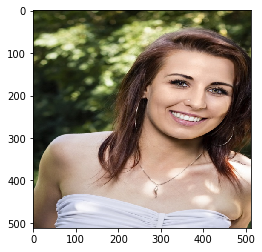

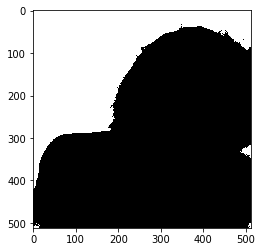

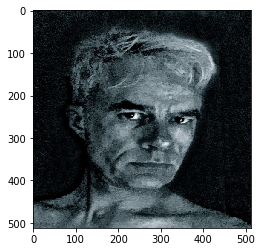

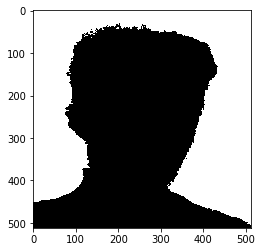

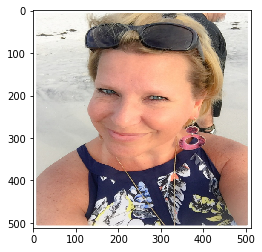

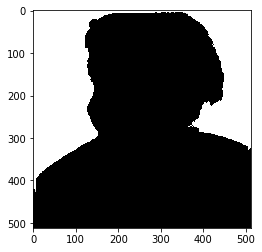

In [21]:
test_img = np.zeros([15, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
test_mask = np.zeros([15, IMG_HEIGHT, IMG_WIDTH, 1])

for i in range(15):
    imgs, masks = test_generator.__getitem__(i)
    img = imgs[0]
    mask = masks[0]
    plt.imshow(img)
    plt.show()
    plt.imshow(mask[:,:,0], cmap = "Greys")
    plt.show()
    test_img[i] = img
    test_mask[i] = mask

In [22]:
predictions = model.predict(test_img, steps = 1, verbose = 1) # NOTE THAT the input values should be normalized to be between 0 and 1

1/1 [==============================] - 1s 1s/step


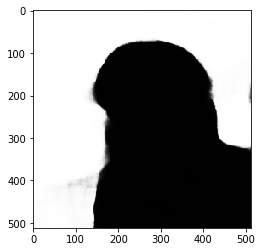

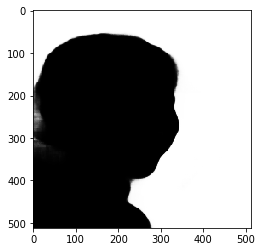

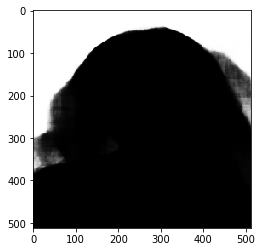

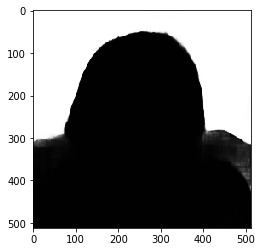

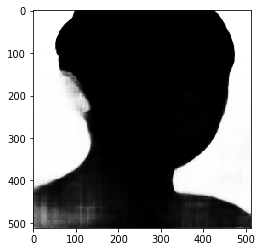

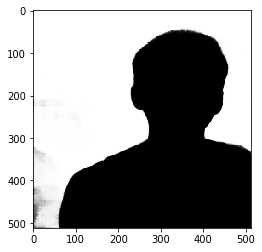

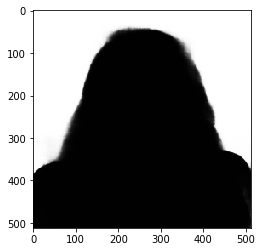

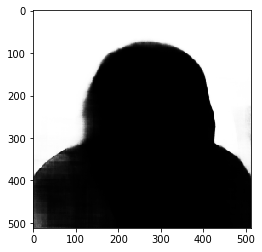

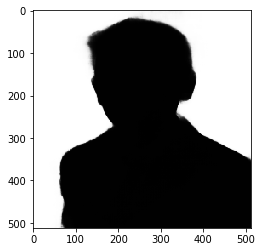

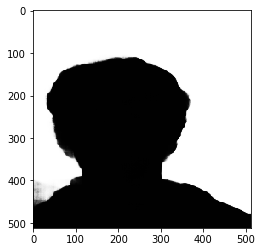

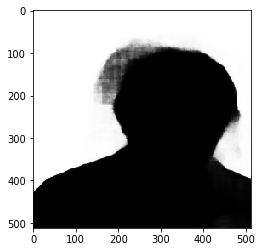

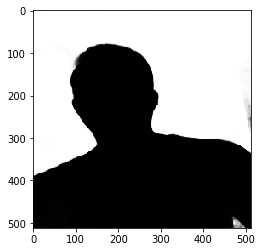

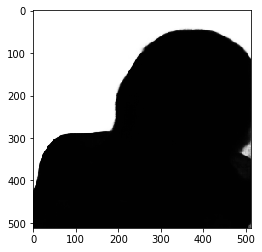

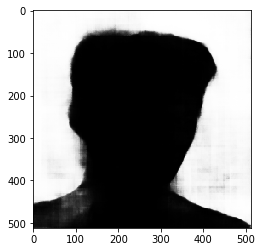

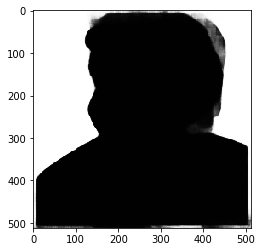

In [23]:
for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(np.uint8)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
#     plt.imshow(Y_train[i][:,:,0], cmap = 'Greys')
    plt.show()
    